# Before We Begin
## Download Your Data
In order to use intraday data (minute-by-minute data, instead of aggregate daily stats) you need to download your data via fitbit.com. Go to Settings > Data Export to view all the download options. For this analysis, I used two downloads:
1. Your Fitbit Data - This Month, Include Data (Body, Activities, Sleep), CSV
2. Export Your Account Archive - took < 15 minutes prepare export for download
    Note this can only be requested once per 24hours.

After both of those are finished downloading, you should have a csv file named "fitbit_export_xxxxxxxx.csv" (where xxxxxxxx is the date of export) and "MyFitbitData.zip". Decompress the "MyFitbitData.zip" file and you should see a folder called "<YourName>" with 10 or so folders inside. This analysis uses only the user-site-export and the sleep-score folders. 

## Download This Repo
In order to run this program properly, first download this repo. Then, copy "fitbit_export_xxxxxxxx.csv" into "fitbit-sleep-analyzer/data" and rename it to "fitbit_export_month.csv". From the unzipped MyFitbitData folder, copy the "/sleep-score" and "/user-site-export" folders into "fitbit-sleep-analyzer/data" as well.
    
## Note About Time Zones & File Privacy
The account archive timestamps are stored in UTC. For ease, I directly converted them to my timezone (Eastern Standard Time, EST) by subtracting 4 hours. 

In addition, none of the 

## Web API Analysis
If you're interested, I also analyzed data via the Web API in a separate jupyter notebook. called fitbit-data-analysis.ipynb on my github at https://github.com/mliu356/fitbit-sleep-analyzer/blob/master/fitbit-data-analysis.ipynb 

# Data Cleaning

In [1]:
import matplotlib
import pandas as pd 
import numpy as np
import json
from collections import namedtuple

# making plots
import matplotlib.pyplot as plt
import seaborn as sns

# math + calculations
import datetime
import math
from __future__ import division

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # to see all columns in the pd dataframe
%config InlineBackend.figure_format = 'retina' # for the crispier version of plots for retina screens

matplotlib.style.use('seaborn-pastel')
plt.rcParams['figure.figsize'] = [12.0, 6.0]

## Import Sleep Score Data
Sleep Score is a measurement that Fitbit calculates via your sleep duration, sleep type breakdown (Deep sleep, Light sleep, REM sleep, Awakenings), restlessness, and resting heart rate. The overall score is the sum of:
* composition score: % deep sleep
* revitalization score: resting heart rate, restlessness
* duration score: length of sleep time
The exact mechanism by which Fitbit calculates these scores is proprietary. 

In [2]:
sleepDataFilename = 'data/sleep-score/sleep_score.csv'
sleepScoreData = pd.read_csv(sleepDataFilename, parse_dates=['timestamp'])
sleepScoreData['Night of Sleep'] = sleepScoreData['timestamp'].apply(lambda x: datetime.datetime(x.year, x.month, x.day - 1))
sleepScoreData = sleepScoreData.rename(columns={'timestamp' : 'wakeTime'})

print("Loaded sleep data db successfully")

Loaded sleep data db successfully


In [136]:
# sleepScoreData

## Import Monthly Sleep Summary
From the monthly export, we can access additional data about sleep, including the sleep/wake times, sleep type breakdown, and awakenings. In this table, "Minutes Awake" refers to the sum of moments when a person wakes up briefly and returns to sleep, often without remembering the next morning. "Minutes Asleep" is the sum of "Minutes Deep Sleep", "Minutes REM Sleep", and "Minutes Light sleep". "Night of sleep" denotes the day that this period of sleep ends; for example, tonight's sleep would record "Night of sleep" as today, regardless of whether you sleep before or after midnight. 

In [137]:
monthDataFilename = 'data/fitbit_export_month.csv'
monthDataFile = open(monthDataFilename, 'r').readlines()

# split data export (month) by type: body data, activity data, sleep data
currentFilename = 'data/body_data_month.csv'
for i in range(0, len(monthDataFile)):
    if monthDataFile[i] == "Body\n":
        currentFilename = 'data/body_data_month.csv'
        open(currentFilename, 'w+')
    elif monthDataFile[i] == "Activities\n":
        currentFilename = 'data/activities_data_month.csv'
        open(currentFilename, 'w+')
    elif monthDataFile[i] == "Sleep\n":
        currentFilename = 'data/sleep_data_month.csv'
        open(currentFilename, 'w+')
    elif monthDataFile[i] != '\n':
        open(currentFilename, 'a').writelines(monthDataFile[i])

In [9]:
sleepSummaryData = pd.read_csv('data/sleep_data_month.csv', parse_dates=['Start Time', 'End Time'])
sleepSummaryData = sleepSummaryData[sleepSummaryData['Minutes Deep Sleep'].notnull()] # remove entries with no recorded Deep sleep (aka naps)
sleepSummaryData['Night of Sleep'] = sleepSummaryData['End Time'].apply(lambda x: datetime.datetime(x.year, x.month, x.day - 1))

print("Loaded sleep data monthly summary successfully")

Loaded sleep data monthly summary successfully


In [138]:
# sleepSummaryData

## Let's Merge Them Together
Note the decreased number of tuples, since the first table (sleep score data) tracked all-time sleep, while the second only records entries from this past month. 

In [139]:
mergedSleepData = pd.merge(sleepScoreData, sleepSummaryData, on=["Night of Sleep"])
# mergedSleepData

## Onto The Exercise Data

To get exercise data, we can read the json files located in the user-site-export folder. For ease, I decided to use the exercise-0.json file, but further analyses could be done using second-by-second heart rate or calorie data. I also chose to filter within the last month so that it would align with my sleep data. 

In [13]:
with open('data/user-site-export/exercise-0.json') as f:
  exerciseDataObj = json.load(f)
# print(json.dumps(exerciseDataObj, indent = 4, sort_keys=True)) # pretty-print for inline viewing

activityCSVFilename = "data/exercise_data_month.csv"
open(activityCSVFilename, 'w+')
open(activityCSVFilename, 'a').writelines("Exercise Time, ActivityName, Steps, Duration, Minutes Sedentary, Minutes Lightly Active, Minutes Fairly Active, Minutes Very Active, Average Heart Rate, Calories, Minutes Fat Burn, Minutes Cardio, Minutes Peak\n")

# write all exercise data within this month to csv
for activityDict in exerciseDataObj:
    activityTimeString = activityDict['startTime']
    activityTime = datetime.datetime.strptime(activityDict['startTime'],"%m/%d/%y %H:%M:%S")
    activityTimeLocal = activityTime - datetime.timedelta(hours=4)
    if activityTimeLocal > (datetime.datetime.today() - datetime.timedelta(days=30)):
        selectedDataString = str(activityTimeLocal) + ", " + activityDict['activityName'] + ", " + str(activityDict['steps']) + ", " + str(activityDict['duration']) + ", "
        selectedDataString += str(activityDict['activityLevel'][0]['minutes']) + ", " + str(activityDict['activityLevel'][1]['minutes']) + ", " + str(activityDict['activityLevel'][2]['minutes']) + ", " + str(activityDict['activityLevel'][3]['minutes']) + ", "
        selectedDataString += str(activityDict['averageHeartRate']) + ", " + str(activityDict['calories']) + ", "
        selectedDataString += str(activityDict['heartRateZones'][1]['minutes']) + ", " + str(activityDict['heartRateZones'][2]['minutes']) + ", " + str(activityDict['heartRateZones'][3]['minutes']) + "\n"
        open(activityCSVFilename, 'a').writelines(selectedDataString)

In [15]:
exerciseData = pd.read_csv('data/exercise_data_month.csv', parse_dates=['Exercise Time'])
exerciseData['Date'] = exerciseData['Exercise Time'].apply(lambda x: datetime.datetime(x.year, x.month, x.day))
exerciseData['Time of Day'] = exerciseData['Exercise Time'].apply(lambda x: x.hour * 60 + x.minute)
# exerciseData

In [140]:
allData = pd.merge(exerciseData, mergedSleepData, left_on=["Date"], right_on=["Night of Sleep"])
# allData

# Data Visualization
Note: After merging the DataFrames, some keys have a leading space. Use allData.keys() to list all possible keys. 

## Current Workout & Sleep Schedule
What does my typical day currently look like? 

In [135]:
summaryData = allData[['Date', ' Duration', ' Calories', 'Time of Day', 'Start Time', 
                       'End Time', 'Time in Bed', 'overall_score', ]]
summaryData['Workout Start'] = summaryData['Time of Day'].apply(lambda x: x / 60)
summaryData['Hours in Bed'] = summaryData['Time in Bed'] / 60
summaryData['Workout Duration'] = summaryData[' Duration'] / 3600000
summaryData['Workout End'] = summaryData['Workout Start'] + summaryData[' Duration'] 
summaryData['Sleep Hour'] = summaryData['Start Time'].apply(lambda x: x.hour + x.minute / 60)
summaryData['Wake Hour'] = summaryData['End Time'].apply(lambda x: x.hour + x.minute / 60)
summaryData['Sleep Time'] = summaryData['Start Time'].apply(lambda x: 24 + x.hour + x.minute / 60)
summaryData['Wake Time'] = summaryData['End Time'].apply(lambda x: 24 + x.hour + x.minute / 60)
summaryData = summaryData.rename(columns={' Calories':'Calories Burned', 'overall_score':'Sleep Score'})

In [134]:
summaryData[['Hours in Bed', 'Sleep Hour', 'Wake Hour', 'Sleep Score', 'Workout Duration', 'Calories Burned']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Hours in Bed,9.0,8.401852,1.535357,5.616667,7.466667,8.883333,8.900000,10.716667
Sleep Hour,9.0,2.166667,1.265076,0.583333,0.766667,2.383333,3.466667,3.683333
Wake Hour,9.0,10.575926,1.229615,9.150000,9.650000,10.166667,11.416667,12.383333
Sleep Score,9.0,78.333333,6.062178,68.000000,76.000000,81.000000,82.000000,87.000000
Workout Duration,9.0,0.589383,0.236697,0.298611,0.426389,0.554722,0.682500,0.966944
Calories Burned,9.0,287.666667,164.003049,60.000000,213.000000,243.000000,388.000000,532.000000


On average, I get 8.4 hours of sleep each night, usually going to bed around 2AM and waking up around 11AM. This seems about right given my current circumstances. The standard deviation is quite high for each of those numbers (1.25 - 1.5 hours), indicating that I should definitely try to keep a more regular sleep schedule. My average sleep score is 78.3, which according to Fitbit's published scale is "Fair." My average workout is ~34 minutes, burning ~287 calories, although the standard deviation on calorie burn is quite high (+/- 164, likely caused by 2 very different workout types).

Note: These values only encompass days where I exercised 1 or more times. 

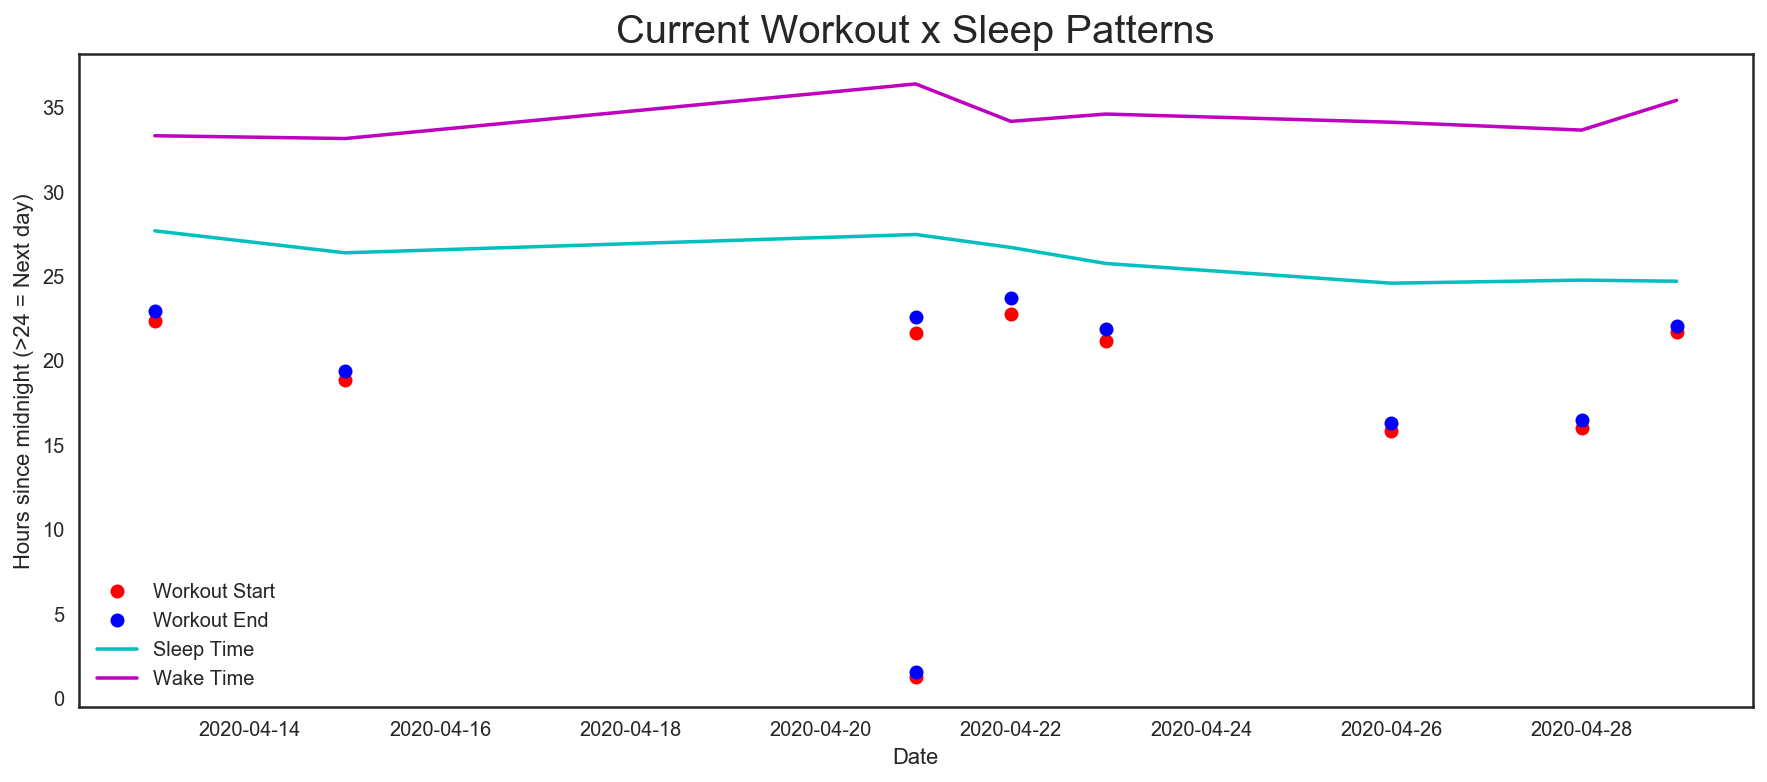

In [115]:
fig = plt.plot(summaryData['Date'], summaryData['Workout Start'], 'ro')
fig = plt.plot(summaryData['Date'], summaryData['Workout End'], 'bo')
fig = plt.plot(summaryData['Date'], summaryData['Sleep Time'], 'c-')
fig = plt.plot(summaryData['Date'], summaryData['Wake Time'], 'm-')
plt.title("Current Workout x Sleep Patterns", fontsize=20)
plt.xlabel("Date")
plt.ylabel("Hours since midnight (>24 = Next day)")
plt.legend()
plt.rcParams['figure.figsize'] = [15.0, 6.0]
plt.show()

## By Workout Type
Although Runs tend to burn 4x as many calories as Aerobic Workouts, they seem to produce lower overall sleep quality and higher restlessness the following night. The difference, however, is marginal and more likely a result of a small sample size (only 2 aerobic workouts) than any meaningful difference. 

In [48]:
allData.groupby([' ActivityName'])[' Steps', ' Duration', ' Average Heart Rate', ' Calories', 'overall_score', 'composition_score', 'revitalization_score', 'duration_score', 'restlessness'].mean()

,Steps,Duration,Average Heart Rate,Calories,overall_score,composition_score,revitalization_score,duration_score,restlessness
ActivityName,,,,,,,,,
Aerobic Workout,1034.5,1.536000e+06,93.000000,85.500000,79.000000,22.000000,18.500000,38.500000,0.089507
Run,5163.0,2.289143e+06,164.714286,345.428571,78.142857,21.714286,18.714286,37.714286,0.110053


## Exercise Time vs. Sleep Quality
Does time of day affect quality of sleep? I measured my sleep scores against the time of my workouts and plotted the line of best fit to discern any trends. Overall, it's still hard to say given the small sample size (and concentration of workout times). Note a small increase in revitalization score and small decrease in duration score later in the day-- potentially indicating less sleep but higher sleep quality?

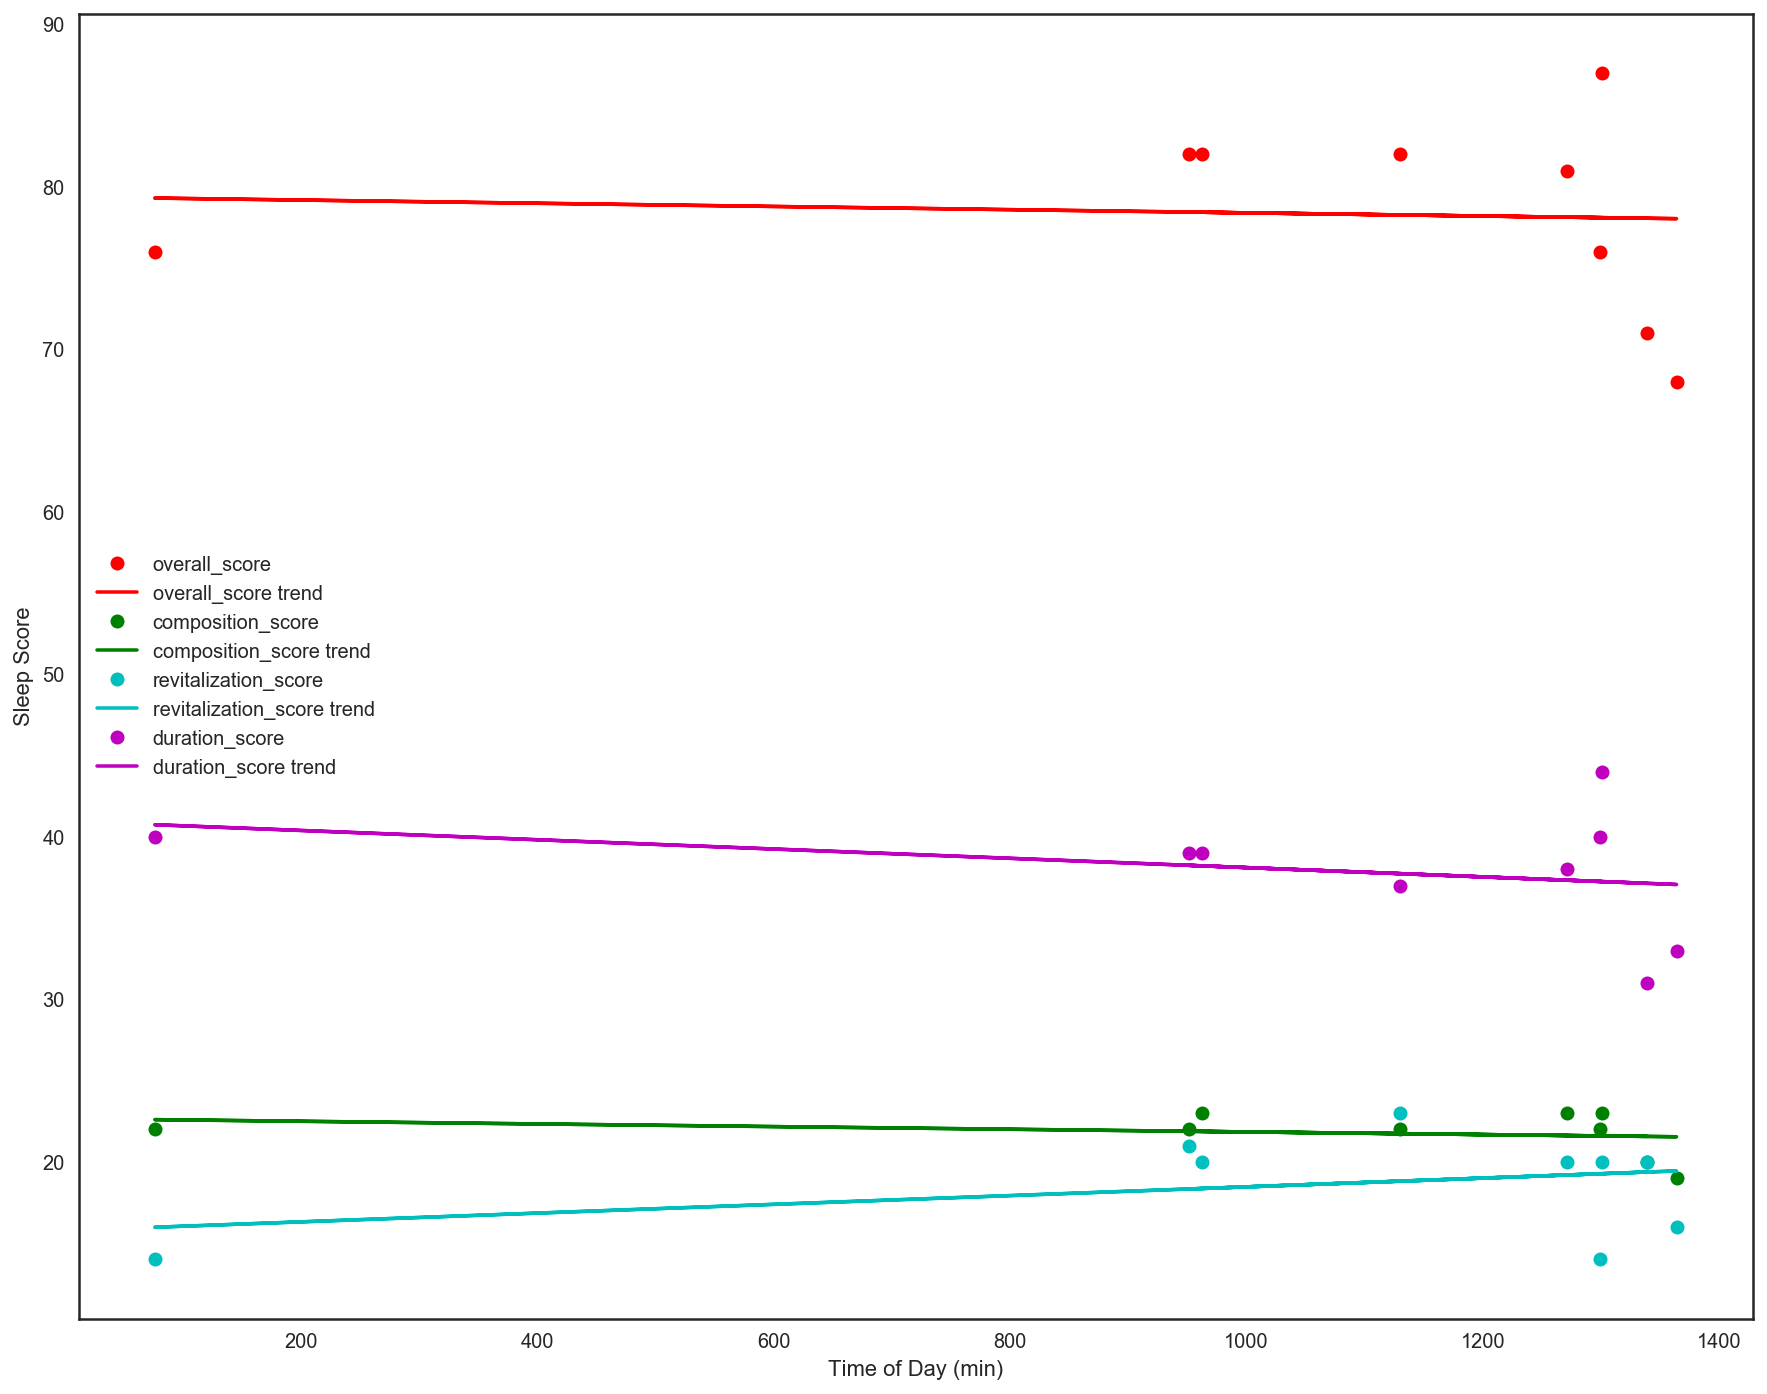

In [24]:
x = allData['Time of Day']
y1 = allData['overall_score']
y2 = allData['composition_score']
y3 = allData['revitalization_score']
y4 = allData['duration_score']

m1, b1 = np.polyfit(x, y1, 1)
m2, b2 = np.polyfit(x, y2, 1)
m3, b3 = np.polyfit(x, y3, 1)
m4, b4 = np.polyfit(x, y4, 1)
plt.plot(x, y1, 'ro')
plt.plot(x, m1*x + b1, 'r', label="overall_score trend")
plt.plot(x, y2, 'go')
plt.plot(x, m2*x + b2, 'g', label="composition_score trend")
plt.plot(x, y3, 'co')
plt.plot(x, m3*x + b3, 'c', label="revitalization_score trend")
plt.plot(x, y4, 'mo')
plt.plot(x, m4*x + b4, 'm', label="duration_score trend")
plt.legend(loc='center left')
plt.ylabel("Sleep Score")
plt.xlabel("Time of Day (min)")
plt.rcParams['figure.figsize'] = [20.0, 20.0]
plt.show()

## Correlation Map between Many Variables

In [21]:
def plot_heatmap(corrmat, title):
    sns.set(style = "white")
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    plt.figure(figsize=(15, 15))
    hm = sns.heatmap(corrmat, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, cmap=cmap)
    hm.set_title(title)
    plt.yticks(rotation=0)
    plt.show()

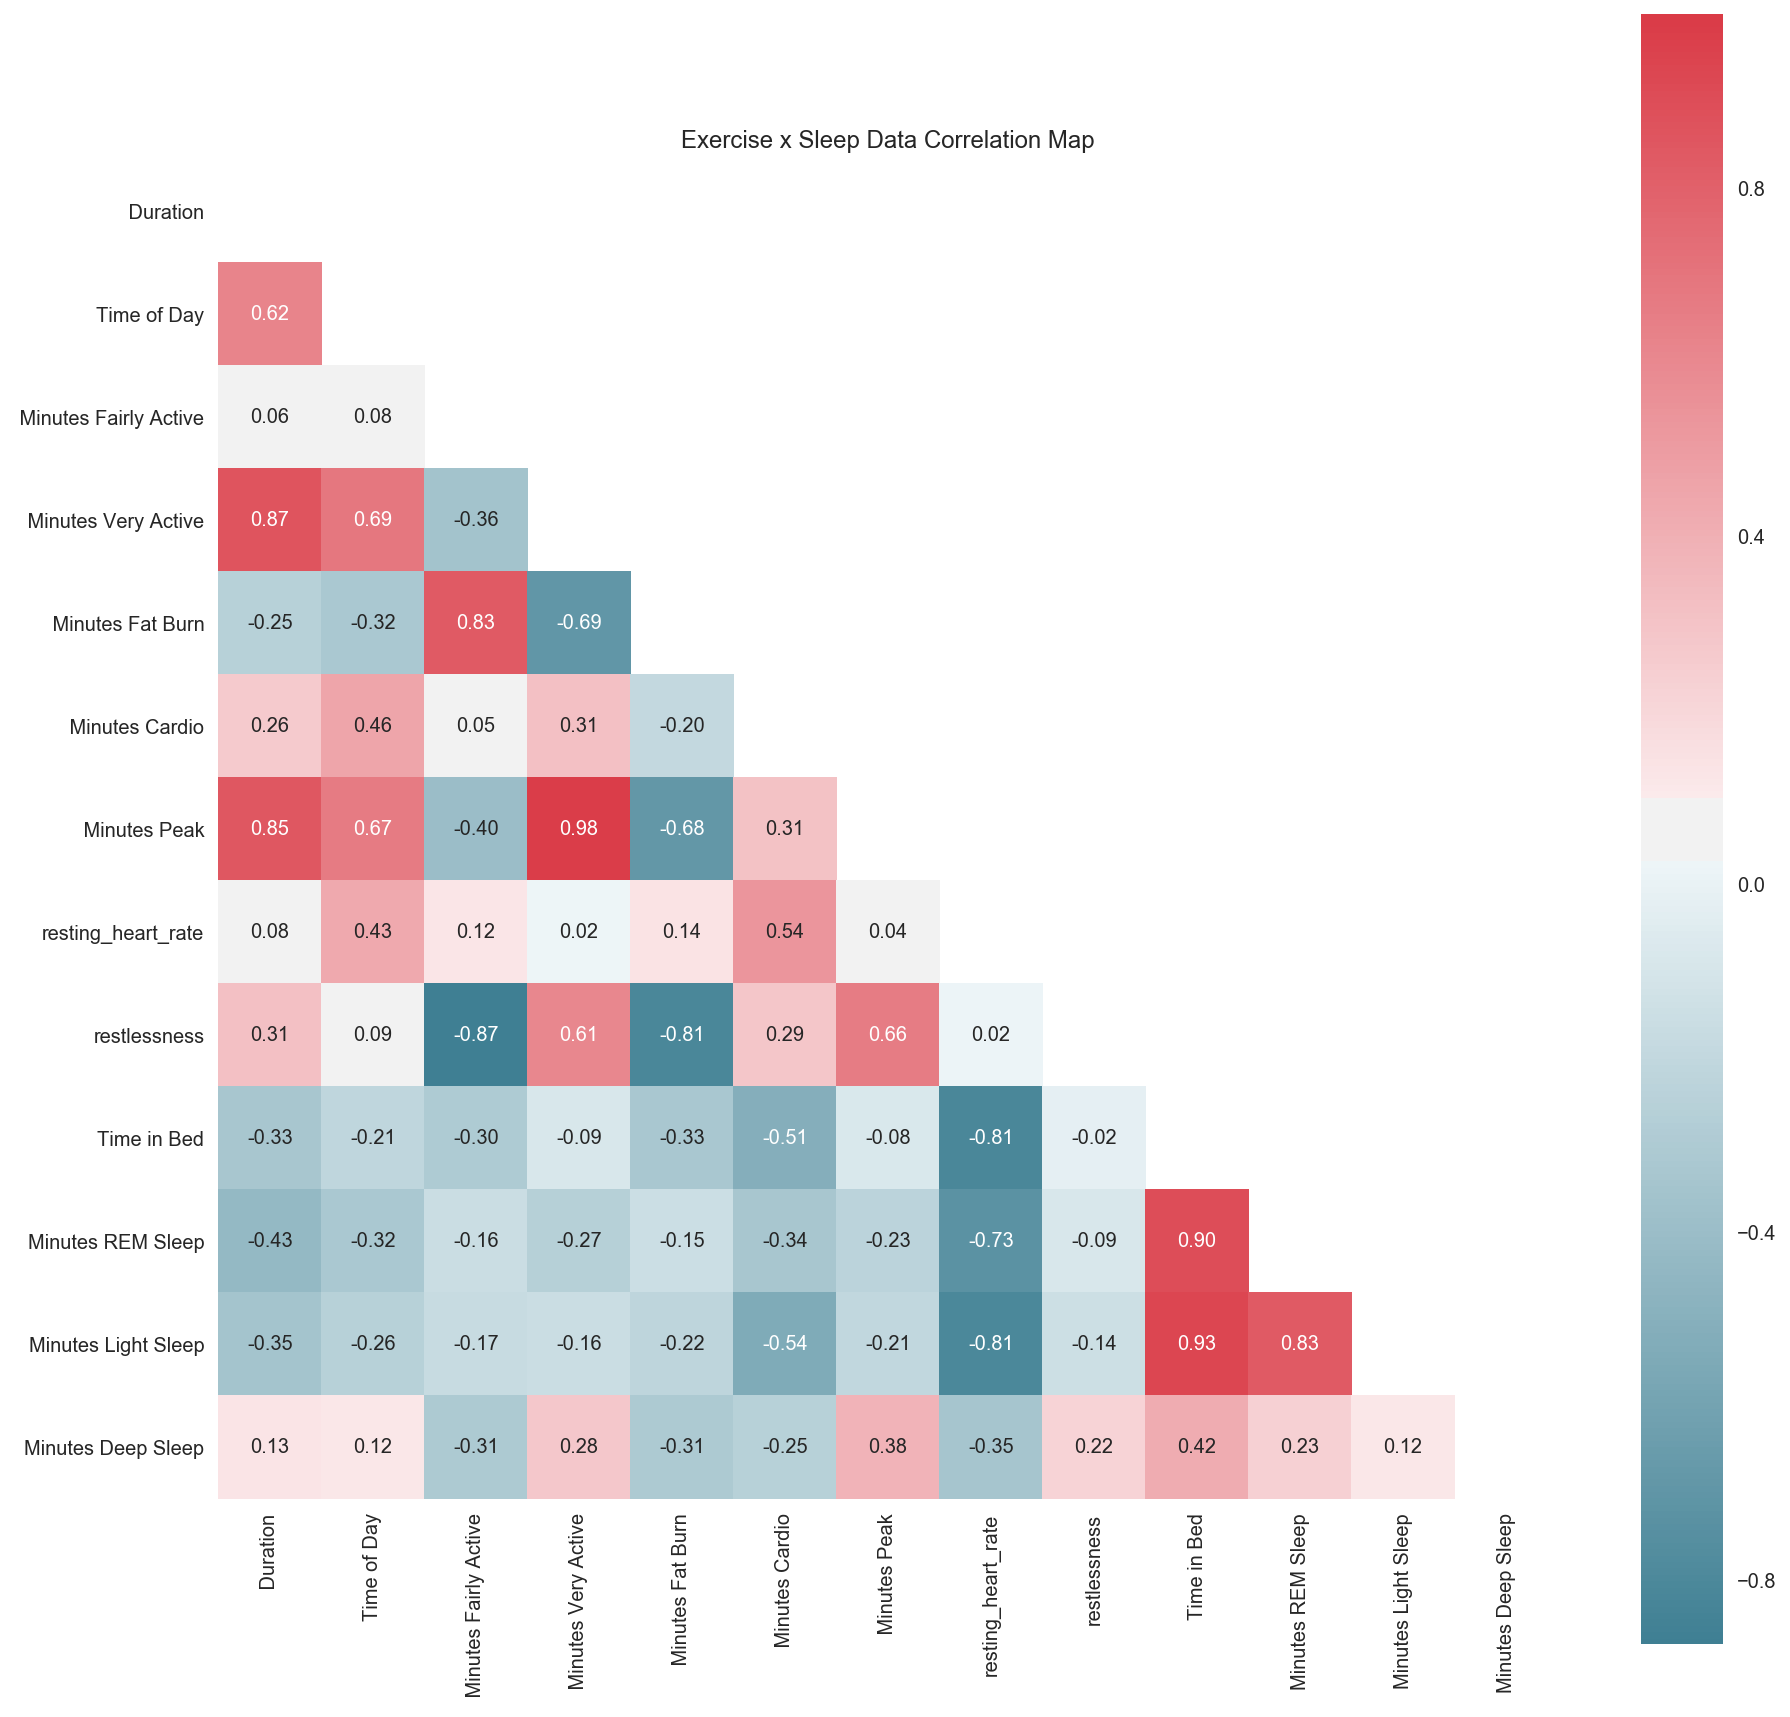

In [22]:
corrdf = allData[[' Duration', 'Time of Day',
                  ' Minutes Fairly Active', ' Minutes Very Active',
                  ' Minutes Fat Burn', ' Minutes Cardio', ' Minutes Peak', 
                  'resting_heart_rate', 'restlessness','Time in Bed', 
                  'Minutes REM Sleep', 'Minutes Light Sleep', 'Minutes Deep Sleep']]
plot_heatmap(corrdf.corr(), 'Exercise x Sleep Data Correlation Map')

I'm most interested in the bottom-left cross-section between minutes of deep/light/REM sleep and minutes/type of activity. The correlations are fairly small but a few interesting insights to note:
* "Minutes Very Active" is positively correlated to deep sleep, while "Minutes Fairly Active" is negatively correlated. Similarly, "Minutes Peak (heart rate zone)" is positively correlated to deep sleep, while "Minutes Cardio (heart rate zone)" is negativley correlated. Note that "Minutes Peak" and "Minutes Very Active" have high positive correlation (0.98). 
    * **This could mean that high-intensity exercises during the day are correlated to more deep sleep the following night.**  
* "Time in Bed" is highly correlated to "Minutes REM sleep" and Minutes Light sleep" but not so much to "Minutes Deep sleep."
    * **This is interesting because deep sleep is primarily for physical and mental recovery and is a main component of high sleep quality; thus, more sleep may not always mean better sleep.** 
* Restlessness (based on minutes awake vs. minutes in bed) is positively correlated to "Minutes very active" but negatively correlated to "Minutes Fairly Active."
* "Time of day" is highly correlated to "Duration" and "Minutes Very Active" meaning that workouts later in the day are likely to be longer and more intense. 